In [1]:
import xarray as xr # needed for reading data
import pandas as pd # Used for stroing data
import numpy as np
import pickle as pkl  # Needed for saving model objects
import os
from itertools import repeat # Needed for repeating a variable multiple times

import matplotlib.pyplot as plt
import matplotlib as mpl

import statsmodels.api as sm    # Used for bot he SARIMA and SARIMAX models
import statsmodels.tsa as sm_tsa # Used for type checking SARIMA models
from sklearn import metrics     # Used for importing various performance measures
import seaborn as sns


In [2]:
# Depending on the machine on which the code is run, data might be stored in different directories.
# Indicate which machine is used to make sure the path to the data can be found.
# Can either be "local" or "Snellius"

MACHINE = 'local'

if MACHINE == 'Snellius':
    pred_var_path = '/gpfs/work1/0/ctdas/awoude/Ritten/predictor_vars/' # For retrieving the set of aggregated scaling vectors

    SAVE_DIR = pers_file_dir = '/gpfs/work1/0/ctdas/awoude/Ritten/trained_models/' # used for storing the trained model

    SF_DIR = '/gpfs/work1/0/ctdas/awoude/Ritten/fitted_sf/' # used for storing the scaling factor produced bij ML models

    RESULTS_DIR = '/gpfs/work1/0/ctdas/awoude/Ritten/results/' # used for storing the trained model

elif MACHINE == 'local':
    pred_var_path = './' # For retrieving the set of aggregated scaling vectors

    SAVE_DIR = pers_file_dir = './models/' # used for storing the trained model

    SF_DIR = './fitted_sf/' # used for storing the scaling factor produced bij ML models

    RESULTS_DIR = './results/'


SARIMA_params = {'order': (2,0,2),             # Defining the regular AR, I and MA dependencies
                 'seasonal_order': (1,0,1,52), # Defining the seasonal dependencies
                 'trend': 'c'                  # Adding an intercept term
                 }


In [22]:
print(var_dat)

<xarray.Dataset>
Dimensions:           (time: 1096, lon: 360, lat: 180, eco_regions: 68)
Coordinates:
  * time              (time) datetime64[ns] 2000-01-01 2000-01-08 ... 2020-12-26
  * lon               (lon) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * lat               (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * eco_regions       (eco_regions) float64 1.0 3.0 4.0 ... 204.0 206.0 209.0
Data variables: (12/51)
    regions           (lat, lon) float32 240.0 240.0 240.0 ... 210.0 210.0 210.0
    grid_cell_weight  (lat, lon) float64 1.079e+08 1.079e+08 ... 1.079e+08
    grid_cell_area    (lat, lon) float32 1.079e+08 1.079e+08 ... 1.079e+08
    TER               (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    monthly_flux      (eco_regions, time) float64 1.726e+06 ... 1.367e+05
    smoothed_flux     (eco_regions, time) float64 1.726e+06 ... 9.337e+04
    ...                ...
    sd_MAX            (eco_regions, time) float64 0.1084 0.1165 ... 0.

In [58]:
with xr.open_dataset('./vars_per_eco_update.nc') as ds:
    var_dat = ds
var_dat['tc_region'] = xr.DataArray(data=((var_dat.eco_regions.values-1)/19).astype('int32')+1,
                                    dims=["eco_regions"],
                                    coords=dict(eco_regions=var_dat.eco_regions)
                                    )


In [ ]:
for tc_region, tc_dat in var_dat.groupby('tc_region'):
    surface_percentage = (tc_dat.eco_area / np.sum(tc_dat.eco_area))*100
    print(f'\nsurface area tc region {tc_region}:')
    print(surface_percentage)

In [ ]:

mock_regions = np.concatenate([range(1,20), range(20,39), range(115, 134), range(134, 153), range(190, 210)])

color_dat = np.interp(mock_regions, [1,19,20,38,115,133,134,152,190,209],
                   [0, 0,# color TC region 1
                    0.2, 0.2, # color TC region 2
                    0.4, 0.4, # color TC region 7
                    0.6, 0.6, # color TC region 8
                    0.8, 1]) # color range TC 11

mock_x = np.linspace(0, 1, 10)
first_entry = zip([mock_regions[0]]*len(mock_x), mock_x, [mock_regions[0]]*len(mock_x))
mock_df = pd.DataFrame(first_entry, columns=['region', 'x_dat', 'y_dat'])
for region in mock_regions[1:]:
    data_triples = zip([region]*len(mock_x), mock_x, [region]*len(mock_x))
    new_entry = pd.DataFrame(data_triples, columns=['region', 'x_dat', 'y_dat'])
    mock_df= pd.concat([mock_df, new_entry], ignore_index = True)
# continent_dict = {1:'North American Boreal',
#                    2:'North American Temperate',
#                    7:'Eurasia Boreal',
#                    8:'Eurasia Temperate',
#                    11:'Europe',
#                   }
# continent_to_index = {1:0,
#                    2:1,
#                    7:2,
#                    8:3,
#                    11:4,
#                   }

fig, ax = plt.subplots(figsize=(8,6))

#norm = mpl.colors.Normalize(vmin=0, vmax=12000, clip=True)
cmap = plt.get_cmap('RdYlGn_r')  # From red to green

# print(mock_df)
colors = plt.cm.hsv_r(color_dat)
alphas = [1 if r>=190 else 0.2 for r in mock_regions]

colors[:,-1] = alphas

mock_df = mock_df.set_index(['x_dat','region'])
mock_df.unstack(['region']).xs('y_dat', axis=1).plot(colormap='jet', color=colors, ax=ax, legend=False)
# mock_df.groupby('region').plot('x_dat', 'y_dat', cmap=cmap, ax=ax)
# cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='vertical',
#                                 ticks=[100, 1000, 10000])
# cb1.set_clim(0,12000)
plt.show()

In [ ]:
colors

In [ ]:
alphas

In [ ]:

def mol_per_sec_to_PgC_per_year(df):
    fac= 86400.*365.*12./1e15 # from mol/region/s to PgC/yr
    for var in ['flux_ME_test', 'flux_ME_train', 'flux_MAE_test', 'flux_MAE_train', 'flux_RMSE_test', 'flux_RMSE_train']:
        df[var] = df[var]*fac
    return df


def load_results(model_name):
    file_name = RESULTS_DIR + model_name + '_results_per_tc.pkl'
    df = pd.read_pickle(file_name)
    df = mol_per_sec_to_PgC_per_year(df)
    return df.set_index(['N_train_years','tc_region'])

used_models = ['SARIMA', 'monthly', 'prior']

results_dict = {model_name: load_results(model_name) for model_name in used_models}

results_df = pd.concat(results_dict)

results_df.index.rename(['model', *list(results_df.index.names)[1:]], inplace=True)


In [ ]:

used_perf_measures = ['ME', 'MAE', 'MAPE', 'RMSE', 'r2']

tc_groups = results_df.groupby(['tc_region'])
tc_regions = list(tc_groups.groups.keys())


eval_space = 'flux'

y_labels = {'flux':[r'[$\mathrm{PgC\cdot yr^{-1}}$]', r'[$\mathrm{PgC\cdot yr^{-1}}$]', '[%]', r'[$\mathrm{PgC\cdot yr^{-1}}$]', '[-]'],
            'sf':['[-]', '[-]', '[%]', '[-]', '[-]']}


#sns.set(style="whitegrid", palette="pastel", color_codes=True)
sns.set(style="whitegrid", palette="colorblind", color_codes=True)
pal = sns.color_palette('colorblind')
# sns.mpl.rc("figure", figsize=(10,6))


plot_train = True
model_alpha_dict = {'prior':1, # alpha TC region 1
                   'CTE2018':1, # alpha TC region 2
                   'monthly':1, # alpha TC region 7
                   'SARIMA':1, # alpha TC region 8
                   'SARIMAX':1, # alpha TC region 11
                  }

# specifiy the color of each tc_region.
model_color_dict = {'prior':1,
                 'smoothed':2,
                 'monthly':0,
                 'SARIMA':4,
                 'SARIMAX':5}

color_indices = [model_color_dict[model] for model in used_models]

colors = [pal[c] for c in color_indices]
# print(colors)
alphas = [model_alpha_dict[model] for model in used_models]
# print(alphas)
colors = [mpl.colors.to_rgba(c, a) for c, a in zip(colors, alphas)]
# print(colors)
continent_dict = {1:'North American Boreal',
                   2:'North American Temperate',
                   7:'Eurasia Boreal',
                   8:'Eurasia Temperate',
                   11:'Europe',
                  }

n_rows = len(used_perf_measures)
n_cols = len(tc_regions)

fig, ax = plt.subplots(n_rows, n_cols,figsize=(20,16), sharex=True)

for j, (tc_region, tc_dat) in enumerate(tc_groups):

    tc_dat.reset_index(inplace=True)
    tc_dat.set_index(['model', 'N_train_years'], inplace=True)
    for i, perf_mes in enumerate(used_perf_measures):

        tc_dat.unstack(['model']).xs(eval_space+'_'+perf_mes + '_test', axis=1).plot(color=colors, ax=ax[i][j], legend=False, linewidth = 4, sort_columns=True)

        if plot_train:
            tc_dat.unstack(['model']).xs(eval_space+'_'+perf_mes + '_train', axis=1).plot(color=colors, ax=ax[i][j], legend=False, linestyle=':', linewidth = 2, sort_columns=True)

        ax[i][j].set_title(perf_mes, style='italic')
        ax[i][j].set_title(perf_mes, style='italic')

for i in range(n_rows-1):
    for j in range(n_cols):
        ax[i][j].axhline(y=0.0, color=pal[7], alpha=0.5, linestyle='--', label='target', linewidth = 4)
        ax[i][j].axhline(y=0.0, color=pal[7], alpha=0.5, linestyle='--', label='target', linewidth = 4)

for i in range(n_rows):
    # ax[i][0].text(x = -0.8, y = 5, s = "row label", rotation = 90, va = "center")
    ax[i][0].set_ylabel(y_labels[eval_space][i])

for j in range(n_cols):
    ax[n_rows-1][j].axhline(y=1.0, color=pal[7], alpha=0.5, linestyle='--', label='target', linewidth = 4)
    ax[n_rows-1][j].axhline(y=1.0, color=pal[7], alpha=0.5, linestyle='--', label='target', linewidth = 4)


pad = 30 # in points
#

figure_title = "Statevector space" if eval_space == 'sf' else "Flux space"
ax[0][0].annotate(figure_title, xy=(.425, .975), xycoords='figure fraction',
            horizontalalignment='center', verticalalignment='top',
            fontsize=20)


col_names = [continent_dict[int(tc_region)] for tc_region in tc_regions]
for axes, col_name in zip(ax[0], col_names):
    axes.annotate(col_name, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline', fontweight="bold")
#
# continent_dict = {1:'North American Boreal',
#                    2:'North American Temperate',
#                    7:'Eurasia Boreal',
#                    8:'Eurasia Temperate',
#                    11:'Europe',
#                   }

original_handles, original_labels = ax[0][0].get_legend_handles_labels()

len_legend = 2*len(used_models)+1 if plot_train else len(used_models)+1


handles = original_handles[:-1]#[None] * len_legend
# handles[-1] = original_handles[-1]

# labels = [None] * len_legend
# labels = original_labels[:-1]

test_labels = ['(test) ' + label for label in original_labels[:len(used_models)]]
print(test_labels)

# for i, label in enumerate(original_labels[:len(used_models)]):
#     labels[i] = '(test) ' + label

if plot_train:
    # overly complicated method for determining the order in which the elements from the legend should be ordered, essentially 'zipping' two lists
    legend_order = sum([[te_lab, tr_lab] for te_lab, tr_lab in zip(range(len(used_models)), range(len(used_models), len(used_models)*2))], [])
    legend_order = legend_order + [len_legend-1]

    train_labels = ['(train) ' + label for label in original_labels[len(used_models):len(used_models)*2]]
    # labels = [label for label in test_labels for label in train_labels]
    labels = test_labels + train_labels + [original_labels[-1]]

    # reordering the labels and handles of the legend
    labels = [labels[idx] for idx in legend_order]
    handles = [handles[idx] for idx in legend_order]
else:
    labels = test_labels +  [original_labels[-1]]

# labels = test_labels + train_labels + [original_labels[-1]]

    # for i, label in enumerate(original_labels[len(used_models):len(used_models)*2], start=len(used_models)):
    #     color = colors[i-len(used_models)]
    #     # handles[i] = mpl.lines.Line2D([0,1], [0.5,0.5], c=color, linestyle=':')
    #     labels[i] ='(train) ' + label


    # handles = np.concatenate([handles, mpl.lines.Line2D([0,1], [0.5,0.5], color=colors[idx*19], label=tc_region+'_test')])
plt.xlim([0,16])

fig.align_ylabels(ax)

# plt.tight_layout()

fig.subplots_adjust(right=0.9)   ##  Need to play with this number to make column names and legend fit.

fig.legend(handles, labels, loc="lower center", ncol=4)

# plt.legend()
# plt.tight_layout()
plt.show()

In [ ]:
sum([[te_lab, tr_lab] for te_lab, tr_lab in zip(range(3), range(3,6))], [])


In [ ]:
def mol_per_sec_to_PgC_per_year(df):
    fac= 86400.*365.*12./1e15 # from mol/region/s to PgC/yr
    for var in ['flux_ME_test', 'flux_ME_train', 'flux_MAE_test', 'flux_MAE_train', 'flux_RMSE_test', 'flux_RMSE_train']:
        df[var] = df[var]*fac
    return df


def load_results(model_name):
    file_name = RESULTS_DIR + model_name + '_results_per_tc.pkl'
    df = pd.read_pickle(file_name)
    df = mol_per_sec_to_PgC_per_year(df)
    return df.set_index(['N_train_years','tc_region'])

used_models = ['monthly', 'SARIMA']

used_perf_measures = ['ME', 'MAE', 'MAPE', 'RMSE', 'r2']

eval_space = 'flux'

y_labels = {'flux':[r'[$\mathrm{PgC\cdot yr^{-1}}$]', r'[$\mathrm{PgC\cdot yr^{-1}}$]', '[%]', r'[$\mathrm{PgC\cdot yr^{-1}}$]', '[-]'],
            'sf':['[-]', '[-]', '[%]', '[-]', '[-]']}

results_dict = {model_name: load_results(model_name) for model_name in used_models}

#sns.set(style="whitegrid", palette="pastel", color_codes=True)
sns.set(style="whitegrid", palette="colorblind", color_codes=True)
pal = sns.color_palette('colorblind')
# sns.mpl.rc("figure", figsize=(10,6))


plot_train = False
trans_alpha_dict = {1:0.5, # alpha TC region 1
                   2:0.5, # alpha TC region 2
                   7:0.5, # alpha TC region 7
                   8:0.5, # alpha TC region 8
                   11:1, # alpha TC region 11
                  }

# specifiy the color of each tc_region.
tc_color_dict = {1:0,
                 2:1,
                 7:2,
                 8:3,
                 11:4}

colors = [pal[c] for c in tc_color_dict.values()]
print(colors)
alphas = list(trans_alpha_dict.values())
print(alphas)
colors = [mpl.colors.to_rgba(c, a) for c, a in zip(colors, alphas)]
print(colors)
continent_dict = {1:'North American Boreal',
                   2:'North American Temperate',
                   7:'Eurasia Boreal',
                   8:'Eurasia Temperate',
                   11:'Europe',
                  }

n_rows = len(used_perf_measures)
n_cols = len(used_models)

fig, ax = plt.subplots(n_rows, n_cols,figsize=(12,12), sharex=True, sharey='row')

for i, perf_mes in enumerate(used_perf_measures):
    for j, (model, df) in enumerate(results_dict.items()):

        if plot_train:
            df.unstack(['tc_region']).xs(eval_space+'_'+perf_mes + '_train', axis=1).plot(color=colors, ax=ax[i][j], legend=False, linestyle=':')

        df.unstack(['tc_region']).xs(eval_space+'_'+perf_mes + '_test', axis=1).plot(color=colors, ax=ax[i][j], legend=False)

        ax[i][j].set_title(perf_mes, style='italic')
        ax[i][j].set_title(perf_mes, style='italic')

for i in range(n_rows-1):
    for j in range(n_cols):
        ax[i][j].axhline(y=0.0, color='b', alpha=0.5, linestyle='--', label='target')
        ax[i][j].axhline(y=0.0, color='b', alpha=0.5, linestyle='--', label='target')

for i in range(n_rows):
    # ax[i][0].text(x = -0.8, y = 5, s = "row label", rotation = 90, va = "center")
    ax[i][0].set_ylabel(y_labels[eval_space][i])

for j in range(n_cols):
    ax[n_rows-1][j].axhline(y=1.0, color='b', alpha=0.5, linestyle='--', label='target')
    ax[n_rows-1][j].axhline(y=1.0, color='b', alpha=0.5, linestyle='--', label='target')

original_handles, original_labels = ax[0][0].get_legend_handles_labels()

pad = 30 # in points
#

figure_title = "Statevector space" if eval_space == 'sf' else "Flux space"
ax[0][0].annotate(figure_title, xy=(.275, .975), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=20)

for axes, col_name in zip(ax[0], used_models):
    axes.annotate(col_name, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline', fontweight="bold")

continent_dict = {1:'North American Boreal',
                   2:'North American Temperate',
                   7:'Eurasia Boreal',
                   8:'Eurasia Temperate',
                   11:'Europe',
                  }


len_legend = 10 if plot_train else 5
handles = [None]*(len_legend+1)
handles[-1] = original_handles[-1]

labels = [None]*(len_legend+1)
labels[-1] = original_labels[-1]

for dict_item, i in zip(continent_dict.items(),range(5)):
    color = colors[i]
    handles[i] = mpl.lines.Line2D([0,1], [0.5,0.5], c=color)
    labels[i] = '(test) ' + dict_item[1]

if plot_train:
    for dict_item, i in zip(continent_dict.items(),range(int(len_legend/2), len_legend)):
        color = colors[i-5]
        handles[i] = mpl.lines.Line2D([0,1], [0.5,0.5], c=color, linestyle=':')
        labels[i] ='(train) ' + dict_item[1]


    # handles = np.concatenate([handles, mpl.lines.Line2D([0,1], [0.5,0.5], color=colors[idx*19], label=tc_region+'_test')])
plt.xlim([0,16])

fig.align_ylabels(ax)

plt.tight_layout()

fig.subplots_adjust(right=0.7)   ##  Need to play with this number to make column names and legend fit.

fig.legend(handles, labels, loc="upper right", ncol=1)

# plt.legend()
# plt.tight_layout()
plt.show()

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745), (0.8705882352941177, 0.5607843137254902, 0.0196078431372549), (0.00784313725490196, 0.6196078431372549, 0.45098039215686275), (0.8352941176470589, 0.3686274509803922, 0.0), (0.8, 0.47058823529411764, 0.7372549019607844)]
[1, 1, 1, 1, 1]
[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745, 1), (0.8705882352941177, 0.5607843137254902, 0.0196078431372549, 1), (0.00784313725490196, 0.6196078431372549, 0.45098039215686275, 1), (0.8352941176470589, 0.3686274509803922, 0.0, 1), (0.8, 0.47058823529411764, 0.7372549019607844, 1)]


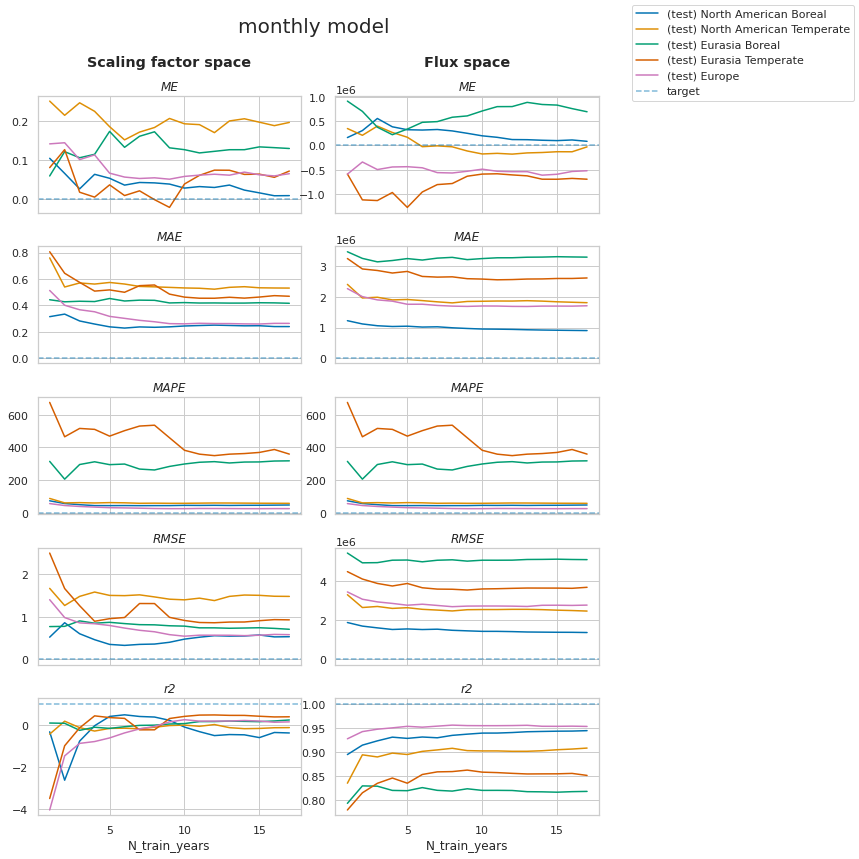

In [60]:
import seaborn as sns

model_name = 'monthly'

#sns.set(style="whitegrid", palette="pastel", color_codes=True)
sns.set(style="whitegrid", palette="colorblind", color_codes=True)
pal = sns.color_palette('colorblind')
sns.mpl.rc("figure", figsize=(10,6))

results = pd.read_pickle(RESULTS_DIR + model_name + '_results_per_tc.pkl')
results = results.set_index(['N_train_years','tc_region'])
plot_train = False
trans_alpha_dict = {1:1, # alpha TC region 1
                   2:1, # alpha TC region 2
                   7:1, # alpha TC region 7
                   8:1, # alpha TC region 8
                   11:1, # alpha TC region 11
                  }

# specifiy the color of each tc_region.
tc_color_dict = {1:0,
                 2:1,
                 7:2,
                 8:3,
                 11:4}

colors = [pal[c] for c in tc_color_dict.values()]
print(colors)
alphas = list(trans_alpha_dict.values())
print(alphas)
colors = [mpl.colors.to_rgba(c, a) for c, a in zip(colors, alphas)]
print(colors)
continent_dict = {1:'North American Boreal',
                   2:'North American Temperate',
                   7:'Eurasia Boreal',
                   8:'Eurasia Temperate',
                   11:'Europe',
                  }
fig, ax = plt.subplots(5,2,figsize=(12,12), sharex=True)

for i, perf_mes in enumerate(['ME', 'MAE', 'MAPE', 'RMSE', 'r2']):
    if plot_train:
        results.unstack(['tc_region']).xs('sf_'+perf_mes + '_train', axis=1).plot(color=colors, ax=ax[i][0], legend=False, linestyle=':')

        results.unstack(['tc_region']).xs('flux_'+perf_mes + '_train', axis=1).plot(color=colors, ax=ax[i][1], legend=False, linestyle=':')

    results.unstack(['tc_region']).xs('sf_'+perf_mes + '_test', axis=1).plot(color=colors, ax=ax[i][0], legend=False)

    results.unstack(['tc_region']).xs('flux_'+perf_mes + '_test', axis=1).plot(color=colors, ax=ax[i][1], legend=False)
    #
    # df.plot('N_train_years', 'sf_'+perf_mes + '_train', ax=ax[i][0], label='train_'+str(label), color=color_dict[label], linestyle=':')
    # df.plot('N_train_years', 'flux_'+perf_mes + '_train', ax=ax[i][1], label='train_'+str(label), color=color_dict[label], linestyle=':')
    # df.plot('N_train_years', 'sf_'+perf_mes + '_test', ax=ax[i][0], label='test_'+str(label), color=color_dict[label])
    # df.plot('N_train_years', 'flux_'+perf_mes + '_test', ax=ax[i][1], label='test_'+str(label), color=color_dict[label])
    ax[i][0].set_title(perf_mes, style='italic')
    ax[i][1].set_title(perf_mes, style='italic')

for i in range(4):
    ax[i][0].axhline(y=0.0, color='b', alpha=0.5, linestyle='--', label='target')
    ax[i][1].axhline(y=0.0, color='b', alpha=0.5, linestyle='--', label='target')

ax[4][0].axhline(y=1.0, color='b', alpha=0.5, linestyle='--', label='target')
ax[4][1].axhline(y=1.0, color='b', alpha=0.5, linestyle='--', label='target')

original_handles, original_labels = ax[0][0].get_legend_handles_labels()

pad = 30 # in points

ax[0][0].annotate(model_name + ' model', xy=(.275, .975), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=20)

for ax, col_name in zip(ax[0], ['Scaling factor space', 'Flux space']):
    ax.annotate(col_name, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline', fontweight="bold")

continent_dict = {1:'North American Boreal',
                   2:'North American Temperate',
                   7:'Eurasia Boreal',
                   8:'Eurasia Temperate',
                   11:'Europe',
                  }


len_legend = 10 if plot_train else 5
handles = [None]*(len_legend+1)
handles[-1] = original_handles[-1]

labels = [None]*(len_legend+1)
labels[-1] = original_labels[-1]

for dict_item, i in zip(continent_dict.items(),range(5)):
    color = colors[i]
    handles[i] = mpl.lines.Line2D([0,1], [0.5,0.5], c=color)
    labels[i] = '(test) ' + dict_item[1]

if plot_train:
    for dict_item, i in zip(continent_dict.items(),range(int(len_legend/2), len_legend)):
        color = colors[i-5]
        handles[i] = mpl.lines.Line2D([0,1], [0.5,0.5], c=color, linestyle=':')
        labels[i] ='(train) ' + dict_item[1]


    # handles = np.concatenate([handles, mpl.lines.Line2D([0,1], [0.5,0.5], color=colors[idx*19], label=tc_region+'_test')])
plt.tight_layout()

fig.subplots_adjust(right=0.7)   ##  Need to play with this number to make column names and legend fit.

fig.legend(handles, labels, loc="upper right", ncol=1)

# plt.legend()
# plt.tight_layout()
plt.show()

       start_year  N_train_years  N_train_obs  N_test_years  N_test_obs  \
1.0          2016              1           53             4         208   
1.0          2015              2          105             4         208   
1.0          2014              3          157             4         208   
1.0          2013              4          209             4         208   
1.0          2012              5          261             4         208   
...           ...            ...          ...           ...         ...   
209.0        2004             13          679             4         208   
209.0        2003             14          731             4         208   
209.0        2002             15          783             4         208   
209.0        2001             16          835             4         208   
209.0        2000             17          888             4         208   

       eco_region   sf_ME_train  sf_MAE_train  sf_MAPE_train  sf_RMSE_train  \
1.0           1.0 -1

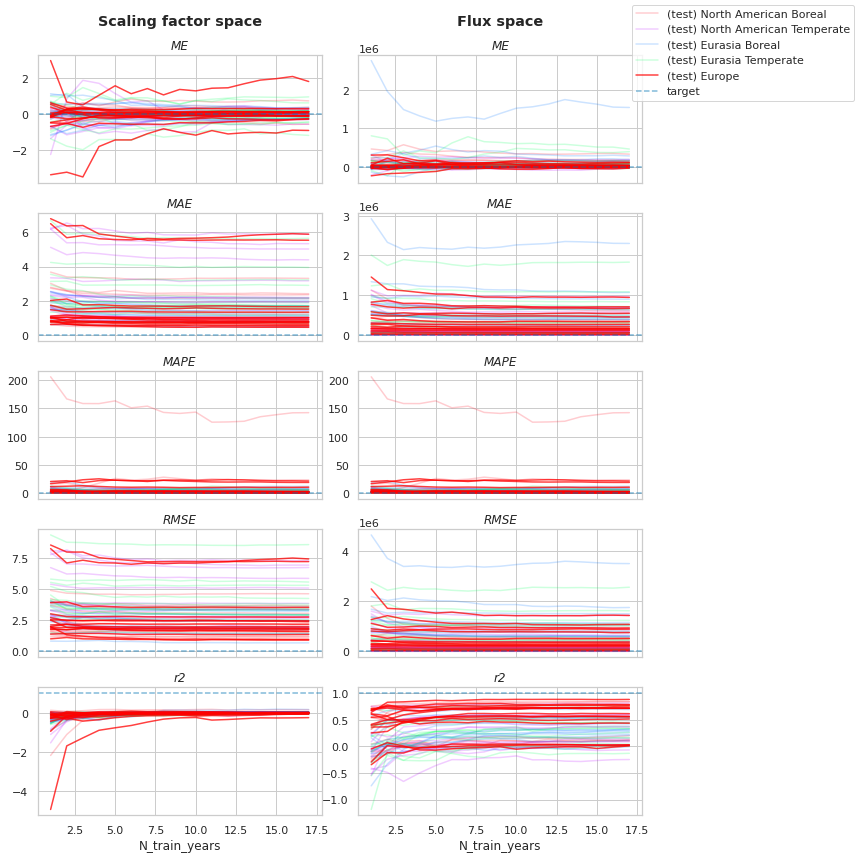

In [44]:
def det_colors(regions, color_ranges):
    color_pos = np.interp(regions,
                     [1,19,20,38,115,133,134,152,190,209],
                     np.concatenate(list(color_ranges.values())))
    return plt.cm.hsv_r(color_pos)

plot_train = False

results = pd.read_pickle(RESULTS_DIR + 'SARIMA_results.pkl')
print(results)
regions = np.unique(results.eco_region)


results = results.set_index(['N_train_years','eco_region'])
trans_color_dict = {1:[0,0], # color TC region 1
                   2:[0.2, 0.2], # color TC region 2
                   7:[0.4, 0.4], # color TC region 7
                   8:[0.6, 0.6], # color TC region 8
                   11:[1,1], # color TC region 11
                  }

trans_alpha_dict = {1:0.2, # alpha TC region 1
                   2:0.2, # alpha TC region 2
                   7:0.2, # alpha TC region 7
                   8:0.2, # alpha TC region 8
                   11:0.75, # alpha TC region 11
                  }

continent_dict = {1:'North American Boreal',
                   2:'North American Temperate',
                   7:'Eurasia Boreal',
                   8:'Eurasia Temperate',
                   11:'Europe',
                  }

colors = det_colors(regions, trans_color_dict)
alphas = [trans_alpha_dict[int((r-1)/19)+1] for r in regions]

colors[:,-1] = alphas
#
# transcom_colors = plt.cm.rainbow(np.linspace(0, 1, 5))
#
# color_dict = {key: color for key, color in zip(range(1,20),europe_colors)}

# colors = colors[:len(regions)]
# results.groupby('eco_region').plot('start_year', 'flux_MAE_test')
fig, ax = plt.subplots(5,2,figsize=(12,12), sharex=True)

for i, perf_mes in enumerate(['ME', 'MAE', 'MAPE', 'RMSE', 'r2']):
    if plot_train:
        results.unstack(['eco_region']).xs('sf_'+perf_mes + '_train', axis=1).plot(color=colors, ax=ax[i][0], legend=False, linestyle=':')

        results.unstack(['eco_region']).xs('flux_'+perf_mes + '_train', axis=1).plot(color=colors, ax=ax[i][1], legend=False, linestyle=':')

    results.unstack(['eco_region']).xs('sf_'+perf_mes + '_test', axis=1).plot(color=colors, ax=ax[i][0], legend=False)

    results.unstack(['eco_region']).xs('flux_'+perf_mes + '_test', axis=1).plot(color=colors, ax=ax[i][1], legend=False)
    #
    # df.plot('N_train_years', 'sf_'+perf_mes + '_train', ax=ax[i][0], label='train_'+str(label), color=color_dict[label], linestyle=':')
    # df.plot('N_train_years', 'flux_'+perf_mes + '_train', ax=ax[i][1], label='train_'+str(label), color=color_dict[label], linestyle=':')
    # df.plot('N_train_years', 'sf_'+perf_mes + '_test', ax=ax[i][0], label='test_'+str(label), color=color_dict[label])
    # df.plot('N_train_years', 'flux_'+perf_mes + '_test', ax=ax[i][1], label='test_'+str(label), color=color_dict[label])
    ax[i][0].set_title(perf_mes, style='italic')
    ax[i][1].set_title(perf_mes, style='italic')

for i in range(4):
    ax[i][0].axhline(y=0.0, color='b', alpha=0.5, linestyle='--', label='target')
    ax[i][1].axhline(y=0.0, color='b', alpha=0.5, linestyle='--', label='target')

ax[4][0].axhline(y=1.0, color='b', alpha=0.5, linestyle='--', label='target')
ax[4][1].axhline(y=1.0, color='b', alpha=0.5, linestyle='--', label='target')
original_handles, original_labels = ax[0][0].get_legend_handles_labels()

pad = 30 # in points

for ax, col_name in zip(ax[0], ['Scaling factor space', 'Flux space']):
    ax.annotate(col_name, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline', fontweight="bold")

continent_dict = {1:'North American Boreal',
                   2:'North American Temperate',
                   7:'Eurasia Boreal',
                   8:'Eurasia Temperate',
                   11:'Europe',
                  }


len_legend = 10 if plot_train else 5
handles = [None]*(len_legend+1)
handles[-1] = original_handles[-1]

labels = [None]*(len_legend+1)
labels[-1] = original_labels[-1]


for dict_item, i in zip(continent_dict.items(),range(5)):
    color = list(det_colors(dict_item[0]*19, trans_color_dict))
    color[-1] = trans_alpha_dict[dict_item[0]]
    handles[i] = mpl.lines.Line2D([0,1], [0.5,0.5], c=color)
    labels[i] = '(test) ' + dict_item[1]

if plot_train:
    for dict_item, i in zip(continent_dict.items(),range(len_legend/2, len_legend)):
        color = list(det_colors(dict_item[0]*19, trans_color_dict))
        color[-1] = trans_alpha_dict[dict_item[0]]
        handles[i] = mpl.lines.Line2D([0,1], [0.5,0.5], c=color, linestyle=':')
        labels[i] ='(train) ' + dict_item[1]


    # handles = np.concatenate([handles, mpl.lines.Line2D([0,1], [0.5,0.5], color=colors[idx*19], label=tc_region+'_test')])
plt.tight_layout()

fig.subplots_adjust(right=0.75)   ##  Need to play with this number to make column names and legend fit.

fig.legend(handles, labels, loc="upper right", ncol=1)


# handles, _ = ax[4][0]
# handles.append(ax[4][0].axhline(y=1.0, color='b', alpha=0.5, linestyle='--', label='target'))
#
# handles, _ = ax[4][1].get_legend_handles_labels()
# handles.append(ax[4][1].axhline(y=1.0, color='b', alpha=0.5, linestyle='--', label='target'))


# plt.legend()
plt.show()

In [34]:
labels = ["some name", "some other name", "horizontal"]
handles